In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn import linear_model, datasets
import seaborn as sns
import itertools
from IPython.display import Image
%matplotlib inline
%matplotlib inline
sns.set()
#plt.style.use('seaborn-white')

In [2]:
def multivariate_gaussian_pdf(X,MU,SIGMA):
    '''Returns the pdf of a nultivariate gaussian distribution
     - X, MU are p x 1 vectors
     - SIGMA is a p x p matrix'''
    #Initialize and reshape
    X = X.reshape(-1,1)
    MU = MU.reshape(-1,1)
    p,_ = SIGMA.shape

    #Compute values
    SIGMA_inv = np.linalg.inv(SIGMA)
    denominator = np.sqrt((2 * np.pi)**p * np.linalg.det(SIGMA))
    exponent = -(1/2) * ((X - MU).T @ SIGMA_inv @ (X - MU))
    
    #Return result
    return float((1. / denominator) * np.exp(exponent) )   

def calculate_boundary(X,MU_k,MU_l, SIGMA,pi_k,pi_l): 
    return (np.log(pi_k / pi_l) - 1/2 * (MU_k + MU_l).T @ np.linalg.inv(SIGMA)@(MU_k - MU_l) + X.T @ np.linalg.inv(SIGMA)@ (MU_k - MU_l)).flatten()[0]   


def LDA_score(X,MU_k,SIGMA,pi_k): 
    #Returns the value of the linear discriminant score function for a given class "k" and 
    # a given x value X
    return (np.log(pi_k) - 1/2 * (MU_k).T @ np.linalg.inv(SIGMA)@(MU_k) + X.T @ np.linalg.inv(SIGMA)@ (MU_k)).flatten()[0]   

def predict_LDA_class(X,MU_list,SIGMA,pi_list): 
    #Returns the class for which the the linear discriminant score function is largest
    scores_list = []
    classes = len(MU_list)
    
    for p in range(classes):
        score = LDA_score(X.reshape(-1,1),MU_list[p].reshape(-1,1),sigma,pi_list[0]) 
        scores_list.append(score)
             
    return np.argmax(scores_list)

def QDA_score(X,MU_k,SIGMA,pi_k): 
    #Returns the value of the linear discriminant score function for a given class "k" and 
    # a given x value X
    
    SIGMA_inv = np.linalg.inv(SIGMA)
    
    return (np.log(pi_k) - 1/2 * np.log(np.linalg.det(SIGMA_inv)) - 1/2 * (X - MU_k).T @ SIGMA_inv @ (X - MU_k)).flatten()[0]   

def predict_QDA_class(X,MU_list,SIGMA_list,pi_list): 
    #Returns the class for which the the linear discriminant score function is largest
    scores_list = []
    classes = len(MU_list)
    
    for p in range(classes):
        score = QDA_score(X.reshape(-1,1),MU_list[p].reshape(-1,1),SIGMA_list[p],pi_list[p]) 
        scores_list.append(score)
             
    return np.argmax(scores_list)

## Iris data and pairplot

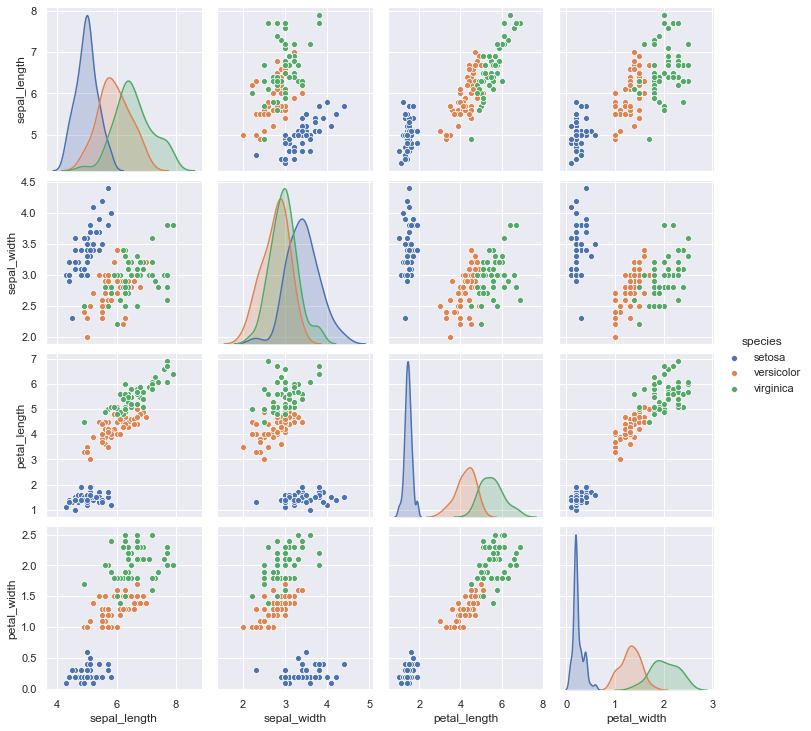

In [3]:
iris = sns.load_dataset("iris")
sns.pairplot(iris, hue="species")

## Focus on petal_width vs petal_length

/Users/sadhik11/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


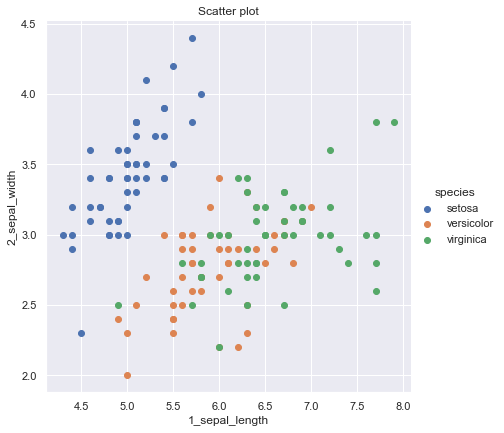

In [4]:
iris = iris.rename(index = str, columns = {'sepal_length':'1_sepal_length','sepal_width':'2_sepal_width', 'petal_length':'3_petal_length', 'petal_width':'4_petal_width'})
sns.FacetGrid(iris, hue="species", size=6) .map(plt.scatter,"1_sepal_length", "2_sepal_width", )  .add_legend()
plt.title('Scatter plot')
df1 = iris[["1_sepal_length", "2_sepal_width",'species']]

## Linear Discriminant Analysis
### Visualizing the gaussian estimations and the boundary lines
### Key assumption - all three Gaussians have the same covariance matrix - hence their shape is the same and only their location differs

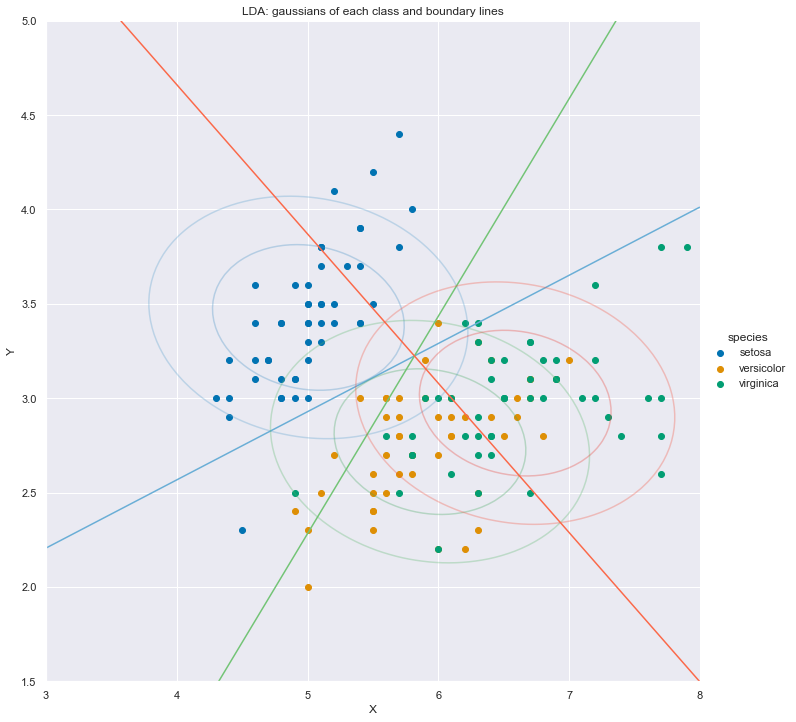

In [5]:
#Estimating the parameters
mu_list = np.split(df1.groupby('species').mean().values,[1,2])
sigma = df1.cov().values
pi_list = df1.iloc[:,2].value_counts().values / len(df1)

# Our 2-dimensional distribution will be over variables X and Y
N = 100
X = np.linspace(3, 8, N)
Y = np.linspace(1.5, 5, N)
X, Y = np.meshgrid(X, Y)

#fig = plt.figure(figsize = (10,10))
#ax = fig.gca()
color_list = ['Blues','Greens','Reds']
my_norm = colors.Normalize(vmin=-1.,vmax=1.)

g = sns.FacetGrid(iris, hue="species", size=10, palette = 'colorblind') .map(plt.scatter,"1_sepal_length", "2_sepal_width", )  .add_legend()
my_ax = g.ax

for i,v in enumerate(itertools.combinations([0,1,2],2)):
    mu = mu_list[i]
    Sigma = sigma

#Computing the cost function for each theta combination
    zz = np.array(  [multivariate_gaussian_pdf( np.array([xx,yy]).reshape(-1,1), mu, Sigma) 
                     for xx, yy in zip(np.ravel(X), np.ravel(Y)) ] )
    
    bb = np.array(  [ calculate_boundary(np.array([xx,yy]).reshape(-1,1),mu_list[v[0]].reshape(-1,1),mu_list[v[1]].reshape(-1,1), sigma , .33,.33)
                     for xx, yy in zip(np.ravel(X), np.ravel(Y)) ] )
    
#Reshaping the cost values    
    Z = zz.reshape(X.shape)
    B = bb.reshape(X.shape)

#Plot the result in 3D
    my_ax.contour( X, Y, Z, 3,cmap = color_list[i] , norm = my_norm, alpha = .3)

    my_ax.contour( X, Y, B , levels = [0] ,cmap = color_list[i]  , norm = my_norm)

    

# Adjust the limits, ticks and view angle
my_ax.set_xlabel('X')
my_ax.set_ylabel('Y')
my_ax.set_title('LDA: gaussians of each class and boundary lines')

plt.show()

## Visualizing the predicted classes based on the LDA score function
### This is an alternative approach to visualizing the boundary lines. We plot the predicted class value on the entire grid, and then show the boundary lines of the predictions.

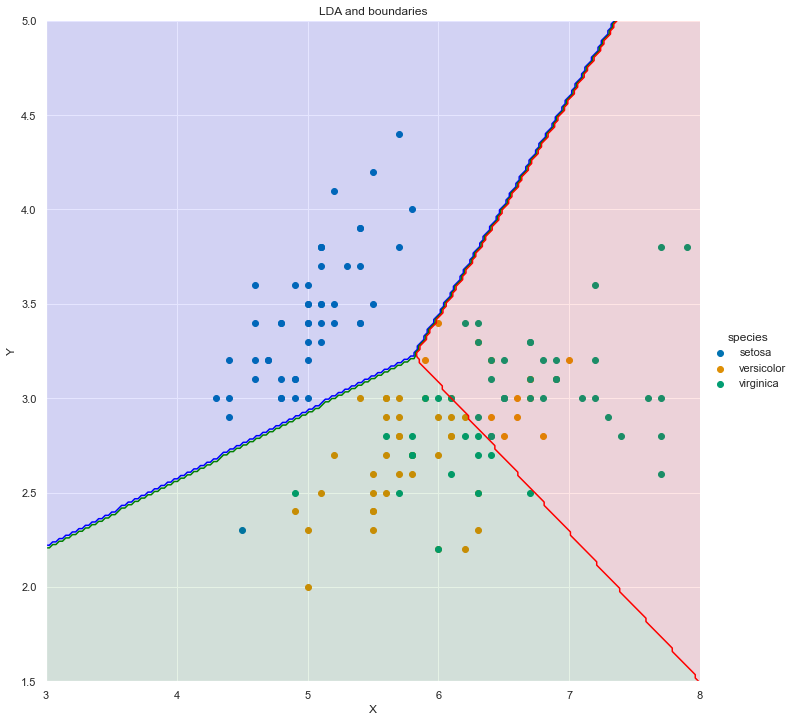

In [6]:
# Our 2-dimensional distribution will be over variables X and Y
N = 200
X = np.linspace(3, 8, N)
Y = np.linspace(1.5, 5, N)
X, Y = np.meshgrid(X, Y)

#Initialize seaborn facetplot
g = sns.FacetGrid(iris, hue="species", size=10, palette = 'colorblind') .map(plt.scatter,"1_sepal_length", "2_sepal_width", )  .add_legend()
my_ax = g.ax #Retrieving the faceplot axes


#Computing the predicted class function for each value on the grid
zz = np.array(  [predict_LDA_class( np.array([xx,yy]).reshape(-1,1), mu_list, Sigma, pi_list) 
                     for xx, yy in zip(np.ravel(X), np.ravel(Y)) ] )
    
#Reshaping the predicted class into the meshgrid shape
Z = zz.reshape(X.shape)


#Plot the filled and boundary contours
my_ax.contourf( X, Y, Z, 2, alpha = .1, colors = ('blue','green','red'))
my_ax.contour( X, Y, Z, 2, alpha = 1, colors = ('blue','green','red'))

# Addd axis and title
my_ax.set_xlabel('X')
my_ax.set_ylabel('Y')
my_ax.set_title('LDA and boundaries')

plt.show()

## LDA Accuracy

In [7]:
#Shape training data
X_data = df1.iloc[:,0:2]
y_labels = df1.iloc[:,2].replace({'setosa':0,'versicolor':1,'virginica':2}).copy()


#Classify and compute accuracy accuracy
y_pred = np.array(  [predict_LDA_class( np.array([xx,yy]).reshape(-1,1), mu_list, Sigma, pi_list) 
                     for xx, yy in zip(np.ravel(X_data.values[:,0]), np.ravel(X_data.values[:,1])) ] )
display(np.mean(y_pred == y_labels))

0.7866666666666666

## Quadratic Discriminant Analysis
### Visualizing the Gaussians estimations with different covariance matrices

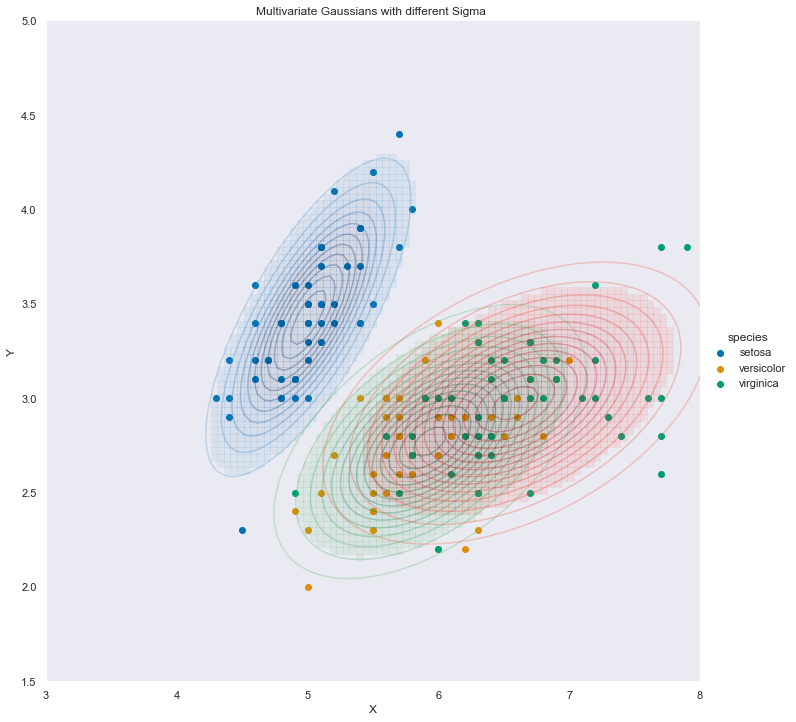

In [8]:
#Estimating the parameters
mu_list = np.split(df1.groupby('species').mean().values,[1,2])
sigma_list = np.split(df1.groupby('species').cov().values,[2,4], axis = 0)
pi_list = df1.iloc[:,2].value_counts().values / len(df1)

# Our 2-dimensional distribution will be over variables X and Y
N = 100
X = np.linspace(3, 8, N)
Y = np.linspace(1.5, 5, N)
X, Y = np.meshgrid(X, Y)

#fig = plt.figure(figsize = (10,10))
#ax = fig.gca()
color_list = ['Blues','Greens','Reds']
my_norm = colors.Normalize(vmin=-1.,vmax=1.)

g = sns.FacetGrid(iris, hue="species", size=10, palette = 'colorblind') .map(plt.scatter, "1_sepal_length", "2_sepal_width",)  .add_legend()
my_ax = g.ax

for i in range(3):
    mu = mu_list[i]
    Sigma = sigma_list[i]

#Computing the cost function for each theta combination
    zz = np.array(  [multivariate_gaussian_pdf( np.array([xx,yy]).reshape(-1,1), mu, Sigma) 
                     for xx, yy in zip(np.ravel(X), np.ravel(Y)) ] )
#Reshaping the cost values    
    Z = zz.reshape(X.shape)
    Zm = np.ma.masked_array(Z, Z < 0.15)

#Plot the result in 3D
    my_ax.contour( X, Y, Z, 15, alpha = .3 ,cmap = color_list[i], norm = my_norm)
    my_ax.pcolor(X,Y,Zm, alpha = .1, cmap = color_list[i], norm = my_norm)


# Adjust the limits, ticks and view angle
my_ax.set_xlabel('X')
my_ax.set_ylabel('Y')
my_ax.set_title('Multivariate Gaussians with different Sigma ')

plt.show()

## Visualizing the quadratic boundary curves

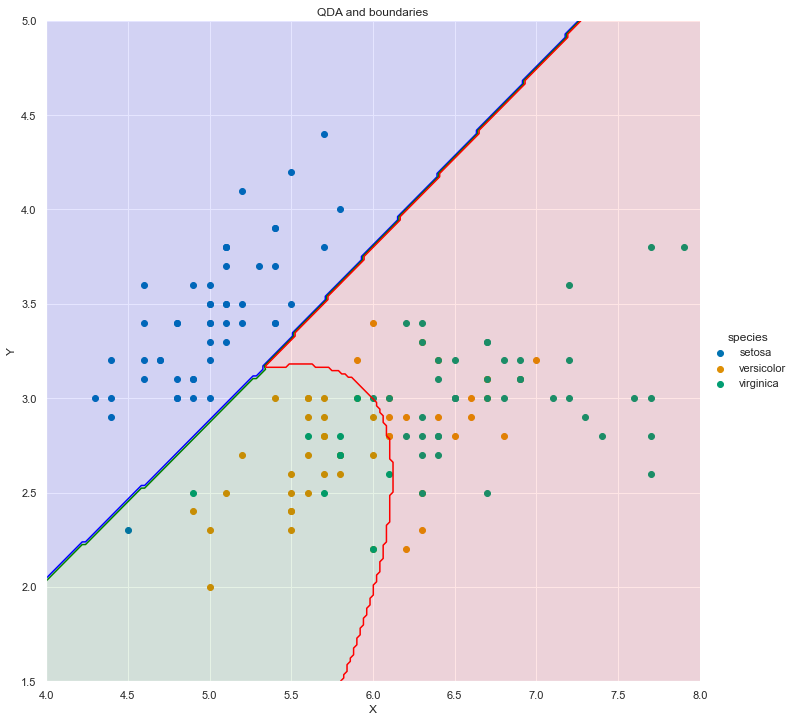

In [9]:
#Estimating the parameters
mu_list = np.split(df1.groupby('species').mean().values,[1,2])
sigma_list = np.split(df1.groupby('species').cov().values,[2,4], axis = 0)
pi_list = df1.iloc[:,2].value_counts().values / len(df1)

# Our 2-dimensional distribution will be over variables X and Y
N = 200
X = np.linspace(4, 8, N)
Y = np.linspace(1.5, 5, N)
X, Y = np.meshgrid(X, Y)

#fig = plt.figure(figsize = (10,10))
#ax = fig.gca()
color_list = ['Blues','Greens','Reds']
my_norm = colors.Normalize(vmin=-1.,vmax=1.)

g = sns.FacetGrid(iris, hue="species", size=10, palette = 'colorblind') .map(plt.scatter, "1_sepal_length", "2_sepal_width",)  .add_legend()
my_ax = g.ax


#Computing the predicted class function for each value on the grid
zz = np.array(  [predict_QDA_class( np.array([xx,yy]).reshape(-1,1), mu_list, sigma_list, pi_list) 
                     for xx, yy in zip(np.ravel(X), np.ravel(Y)) ] )
    
#Reshaping the predicted class into the meshgrid shape
Z = zz.reshape(X.shape)


#Plot the filled and boundary contours
my_ax.contourf( X, Y, Z, 2, alpha = .1, colors = ('blue','green','red'))
my_ax.contour( X, Y, Z, 2, alpha = 1, colors = ('blue','green','red'))

# Addd axis and title
my_ax.set_xlabel('X')
my_ax.set_ylabel('Y')
my_ax.set_title('QDA and boundaries')

plt.show()

## Implementation using Sklearn

In [10]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
X_data = df1.iloc[:,0:2]
y_labels = df1.iloc[:,2].replace({'setosa':0,'versicolor':1,'virginica':2}).copy()

qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_data,y_labels)

QuadraticDiscriminantAnalysis(store_covariance=True)

/Users/sadhik11/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


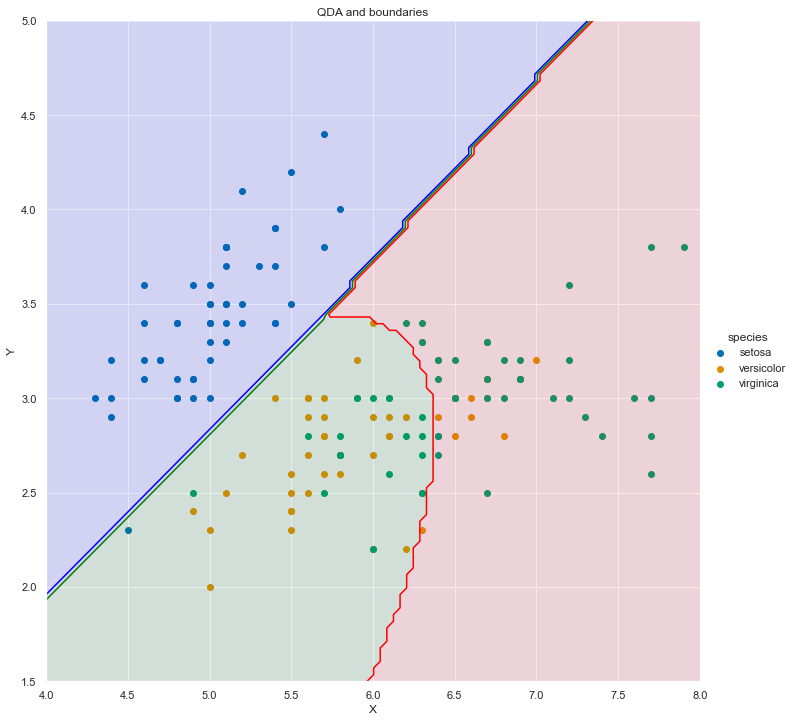

In [11]:
#Estimating the parameters
mu_list = np.split(df1.groupby('species').mean().values,[1,2])
sigma_list = np.split(df1.groupby('species').cov().values,[2,4], axis = 0)
pi_list = df1.iloc[:,2].value_counts().values / len(df1)

# Our 2-dimensional distribution will be over variables X and Y
N = 100
X = np.linspace(4, 8, N)
Y = np.linspace(1.5, 5, N)
X, Y = np.meshgrid(X, Y)

#fig = plt.figure(figsize = (10,10))
#ax = fig.gca()
color_list = ['Blues','Greens','Reds']
my_norm = colors.Normalize(vmin=-1.,vmax=1.)

g = sns.FacetGrid(iris, hue="species", size=10, palette = 'colorblind') .map(plt.scatter, "1_sepal_length", "2_sepal_width",)  .add_legend()
my_ax = g.ax


#Computing the predicted class function for each value on the grid
zz = np.array(  [qda.predict( np.array([[xx,yy]])) 
                     for xx, yy in zip(np.ravel(X), np.ravel(Y)) ] )
    
#Reshaping the predicted class into the meshgrid shape
Z = zz.reshape(X.shape)


#Plot the filled and boundary contours
my_ax.contourf( X, Y, Z, 2, alpha = .1, colors = ('blue','green','red'))
my_ax.contour( X, Y, Z, 2, alpha = 1, colors = ('blue','green','red'))

# Addd axis and title
my_ax.set_xlabel('X')
my_ax.set_ylabel('Y')
my_ax.set_title('QDA and boundaries')

plt.show()

## QDA Accuracy

In [12]:
#Numpy accuracy
y_pred = np.array(  [predict_QDA_class( np.array([xx,yy]).reshape(-1,1), mu_list, sigma_list, pi_list) 
                     for xx, yy in zip(np.ravel(X_data.values[:,0]), np.ravel(X_data.values[:,1])) ] )
display(np.mean(y_pred == y_labels))

#predict_QDA_class( np.array([xx,yy]).reshape(-1,1), mu_list, sigma_list, pi_list) 

#Sklearn accuracy
display(qda.score(X_data,y_labels))

0.7866666666666666

0.8